# Описание проекта
Я аналитик популярного сервиса аренды самокатов GoFast. Мне передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

    без подписки
      
        абонентская плата отсутствует;
        стоимость одной минуты поездки — 8 рублей;
        стоимость старта (начала поездки) — 50 рублей;
    с подпиской Ultra
      
        абонентская плата — 199 рублей в месяц;
        стоимость одной минуты поездки — 6 рублей;
        стоимость старта — бесплатно.


Описание данных:

В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи — users_go.csv
	
user_id	уникальный идентификатор пользователя

name	имя пользователя

age	    возраст

city	город

subscription_type	тип подписки (free, ultra)


Поездки — rides_go.csv
	
user_id	    уникальный идентификатор пользователя

distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)

duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

date	    дата совершения поездки


Подписки — subscriptions_go.csv
	
subscription_type	тип подписки
 
minute_price	стоимость одной минуты поездки по данной подписке

start_ride_price	стоимость начала поездки

subscription_fee	стоимость ежемесячного платежа


#### Шаг 1. Загрузка данных

In [1]:
import pandas as pd # импортируем необходимые библиотеки
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st
from math import sqrt
from scipy.stats import binom, norm

In [2]:
users = pd.read_csv('users_go.csv') # импортируем данные о пользователях

In [3]:
users.head() # смотрим первые 5 строк датафрейма

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info() # выводим общую информацию о данных о пользователях

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
# импортируем данные о поездках пользователей, переводим информацию о дате в тип дата
rides = pd.read_csv('rides_go.csv', parse_dates=['date'], dayfirst=True) 

In [6]:
rides.head() # смотрим первые 5 строк датафрейма

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
rides.info() # выводим общую информацию о данных о поездках пользователей

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [8]:
subscriptions = pd.read_csv('subscriptions_go.csv') # импортируем данные о подписках

In [9]:
subscriptions.head() # смотрим первые 5 строк датафрейма

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
subscriptions.info() # выводим общую информацию о данных о подписках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Итог шага №1: все данные были успешно загружены и сохранены в 3 датафрейма.

#### Шаг 2. Предобработка данных

In [11]:
 # Ищем пропуски в датафрейме с информацией о пользователях. Как видно из таблицы ниже пропуски в данных отсутствуют.
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [12]:
users.duplicated().sum() # Ищем дубликаты в датафрейме с информацией о пользователях. Дубликаты в данных присутствуют.

31

In [13]:
users = users.drop_duplicates() # удаляем дубликаты в датафрейме с информацией о пользователях.
users.duplicated().sum() # убеждаемся, что дубликаты в датафрейме теперь отсутствуют.

0

In [14]:
 # Ищем пропуски в датафрейме с информацией о поездках пользователей. Как видно из таблицы ниже пропуски в данных отсутствуют.
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [15]:
rides.duplicated().sum() # Ищем дубликаты в датафрейме с информацией о поездках пользователей. Дубликаты в данных отсутствуют.

0

In [16]:
 # Ищем пропуски в датафрейме с информацией о подписках. Как видно из таблицы ниже пропуски в данных отсутствуют.
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [17]:
subscriptions.duplicated().sum() # Ищем дубликаты в датафрейме с информацией о подписках. Дубликаты в данных отсутствуют.

0

In [18]:
# переводим столбец date к типу даты и добавляем еще один столбец с информацией о месяце.
rides['date'] = rides['date'].dt.date
rides['month'] = rides['date'].astype('datetime64[M]')

In [19]:
rides.head() # смотрим первые 5 строк датафрейма. Новый столбец добавился корректно.

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,2021-01-01
1,1,2617.592153,15.816871,2021-01-18,2021-01-01
2,1,754.159807,6.232113,2021-04-20,2021-04-01
3,1,2694.783254,18.511000,2021-08-11,2021-08-01
4,1,4028.687306,26.265803,2021-08-28,2021-08-01


Итог шага №2: Проведена предобработка данных. В датафреймах пропусков обнаружено не было. В датафрейме с информацией о пользователях был обнаружен и удален 31 дубликат. Столбец date в датафрейме с информацией о поездках пользователей был преобразован к типу дата, а также добавлен новый столбец с информацией о месяце для каждой поездки пользователя.

#### Шаг 3. Исследовательский анализ данных

In [20]:
# собираем информацию о городах, в которых пользователи сервиса совершают свои поездки
cities = users.groupby('city')['user_id'].count() 

In [21]:
cities.sort_values(ascending=False) # количество пользователей по городам

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: user_id, dtype: int64

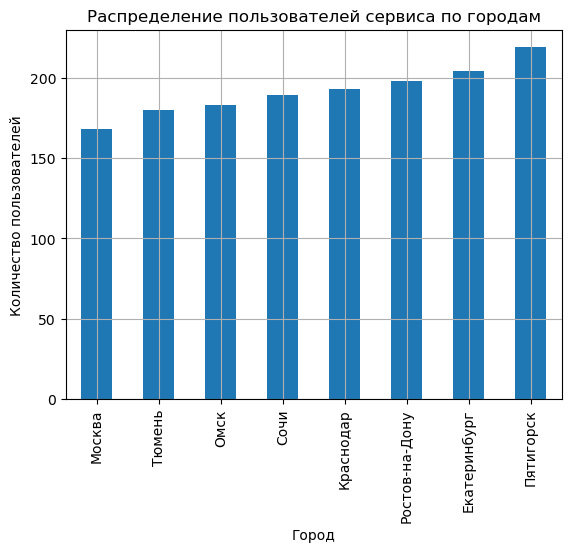

In [22]:
cities.sort_values().plot(kind='bar', grid=True) # визуализируем информацию о городах
plt.title('Распределение пользователей сервиса по городам')
plt.xlabel('Город')
plt.ylabel('Количество пользователей', rotation=90); 

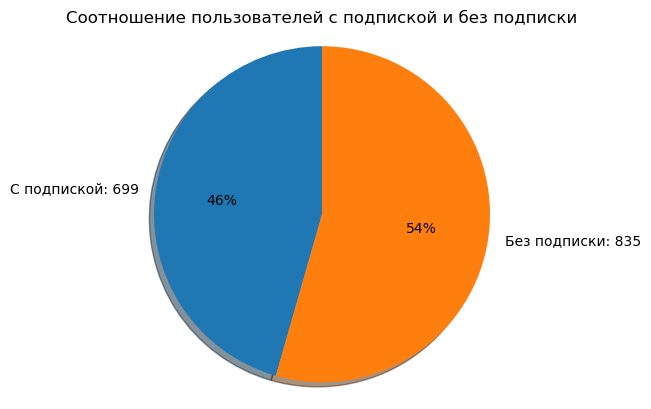

In [23]:
# Визуализируем данные о наличии подписки у пользователей сервиса
users_with_subscription = users.query('subscription_type == "ultra"')['user_id'].count()
users_without_subscription = users.query('subscription_type == "free"')['user_id'].count()
labels = f'С подпиской: {users_with_subscription}', f'Без подписки: {users_without_subscription}'
sizes = [users_with_subscription, users_without_subscription]
fig1, ax1 = plt.subplots()
ax1.set_title("Cоотношение пользователей с подпиской и без подписки")
ax1.pie(sizes,  labels=labels, autopct='%1.0f%%', shadow=True, startangle=90)
ax1.axis('equal');

In [24]:
users_age = users.groupby('age')['user_id'].count() # собираем данные о возрасте пользователей сервиса


In [25]:
users_age.sort_values(ascending=False) # распределение пользователей по возрасту

age
25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: user_id, dtype: int64

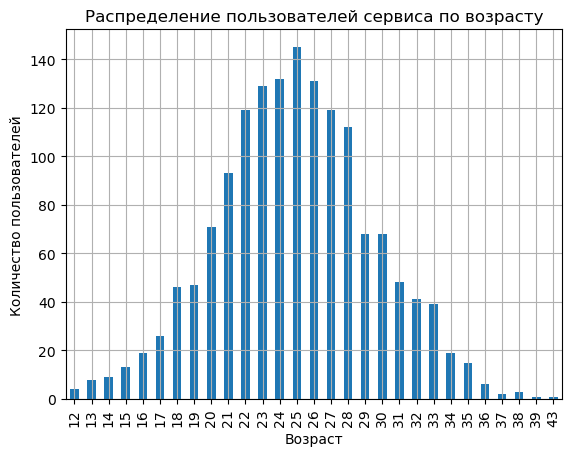

In [26]:
# Визуализируем данные о возрасте пользователей сервиса
users_age.plot(kind='bar', grid=True)
plt.title('Распределение пользователей сервиса по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей', rotation=90); 

In [27]:
rides['distance'].describe() # информация о дальности поездок пользователей сервиса

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

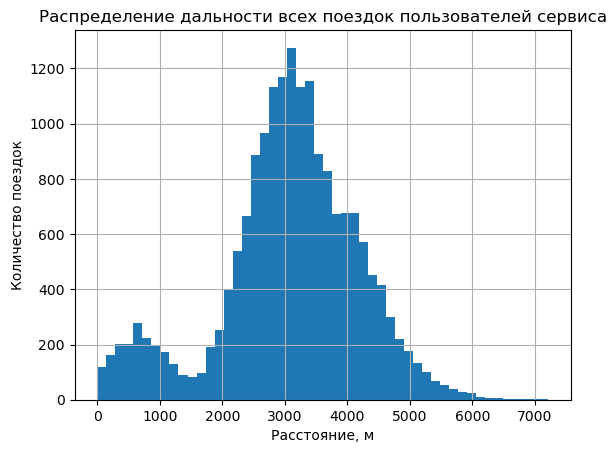

In [75]:
# визуализируем информацию о дальности поездок пользователей сервиса
rides['distance'].hist(bins=50)
plt.title('Распределение дальности всех поездок пользователей сервиса')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок', rotation=90);

In [29]:
rides['duration'].describe() # информация о длительности поездок пользователей сервиса

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

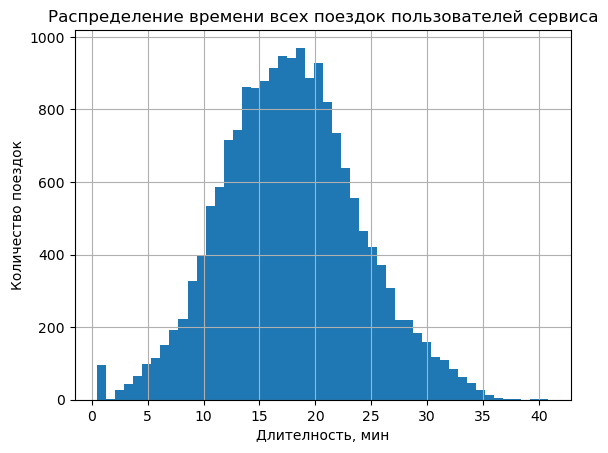

In [76]:
# визуализируем информацию о длительности поездок пользователей сервиса
rides['duration'].hist(bins=50)
plt.title('Распределение времени всех поездок пользователей сервиса')
plt.xlabel('Длителность, мин')
plt.ylabel('Количество поездок', rotation=90); 

Итог шага №3: Был проведен исследовательский анализ данных. Было установлено, что данные содержат информацию о пользователях из 8 городов России. Среди 8 городов наибольшее количество пользователей сервиса совершают поездки в Пятигорске (219 человек), а наименьшее в Москве (168 человек). 54% (835 человек) всех пользователей не имеют подписки на сервис, а 46% (699 человек) ее оформили. Большинство пользователей имеют возраст в интервале 22-28 лет. Средняя дальность поездки пользователя составляет 3133 м, причем четверь всех поездок совершается на расстояние не превышающее 2543 м, а 3/4 всех поездок имеют дальность не более 3776 м. Средняя длительность поездки пользователя составляет 17.7 минут, причем длительность четверти всех поездок не превышает 13.6 минут, а 3/4 всех поездок имеют длительность не более 21.7 минут.  

#### Шаг 4. Объединение данных

In [31]:
users.shape # посмотрим на размер датафрейма

(1534, 5)

In [32]:
rides.shape # посмотрим на размер датафрейма

(18068, 5)

После объединения ожидаем датафрейм с 18068 строками и 9 столбцами.

In [33]:
 # объединяем датафреймы с информацией о пользователях с информацией о их поездках.
data_2 = users.merge(rides, on='user_id', how='inner')

In [34]:
data_2.head() # выведем 5 строк нового датафрейма

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,2021-01-01
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,2021-01-01
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,2021-04-01
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,2021-08-01
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,2021-08-01


In [35]:
# посмотрим на размер датафрейма. Размер соответствует ожиданию - информация о поездках дополнилась информацией о пользователях.
data_2.shape

(18068, 9)

In [36]:
subscriptions.shape

(2, 4)

Объеденим subscriptions с датафреймом data_2. Ожидаем датафрейм с 18068 строками и 12 столбцами.

In [37]:
# объединяем датафреймы с информацией о пользователях и их поездках с информацией о подписках
data = data_2.merge(subscriptions, on='subscription_type', how='inner')

In [38]:
data.head() # выведем 5 строк нового датафрейма

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,2021-01-01,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,2021-01-01,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,2021-04-01,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,2021-08-01,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,2021-08-01,6,0,199


In [39]:
# посмотрим на размер датафрейма.
# Размер соответствует ожиданию - информация о поездках и пользователях дополнилась информацией о подписках.
data.shape

(18068, 12)

In [40]:
# создаем датафрейм с информацией о пользователях с подпиской
data_with_subscription = data.query('subscription_type == "ultra"')

In [41]:
data_with_subscription.head() # выведем 5 строк нового датафрейма

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,2021-01-01,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,2021-01-01,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,2021-04-01,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,2021-08-01,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,2021-08-01,6,0,199


In [42]:
data_with_subscription.shape # посмотрим на размер датафрейма.

(6500, 12)

In [43]:
# создаем датафрейм с информацией о пользователях без подписки
data_without_subscription = data.query('subscription_type == "free"')

In [44]:
data_without_subscription.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,2021-01-01,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2021-02-01,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2021-02-01,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2021-02-01,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2021-02-01,8,50,0


In [45]:
data_without_subscription.shape # посмотрим на размер датафрейма.

(11568, 12)

In [46]:
data_with_subscription['distance'].describe() # информация о дальности поездкок пользователей с подпиской

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

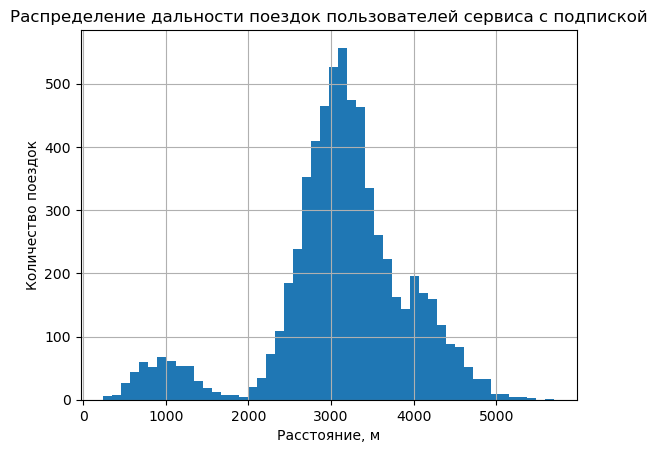

In [77]:
data_with_subscription['distance'].hist(bins=50)
plt.title('Распределение дальности поездок пользователей сервиса с подпиской')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок', rotation=90); 

In [48]:
data_without_subscription['distance'].describe() # информация о дальности поездкок пользователей без подписки  

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

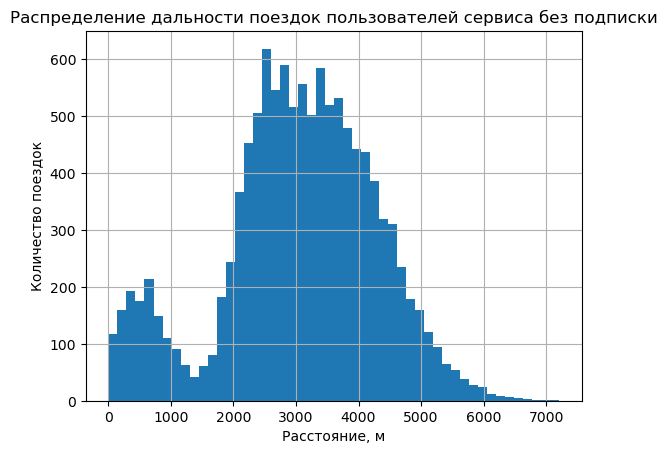

In [78]:
data_without_subscription['distance'].hist(bins=50)
plt.title('Распределение дальности поездок пользователей сервиса без подписки')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок', rotation=90);

In [50]:
data_with_subscription['duration'].describe() # информация о длительности поездкок пользователей с подпиской

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

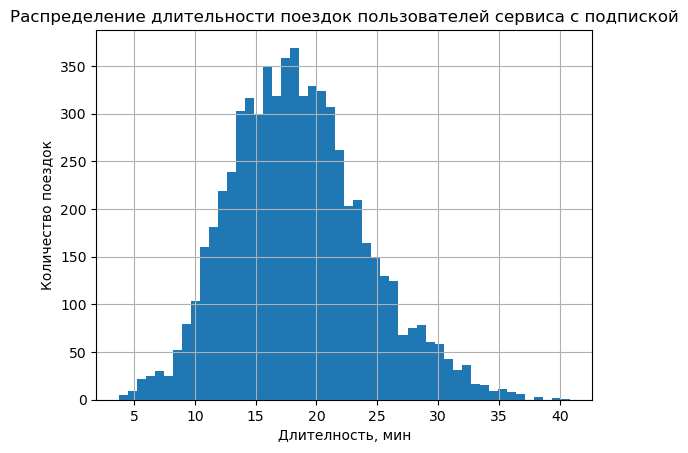

In [79]:
data_with_subscription['duration'].hist(bins=50)
plt.title('Распределение длительности поездок пользователей сервиса с подпиской')
plt.xlabel('Длителность, мин')
plt.ylabel('Количество поездок', rotation=90);

In [52]:
data_without_subscription['duration'].describe()  # информация о длительности поездкок пользователей без подписки

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

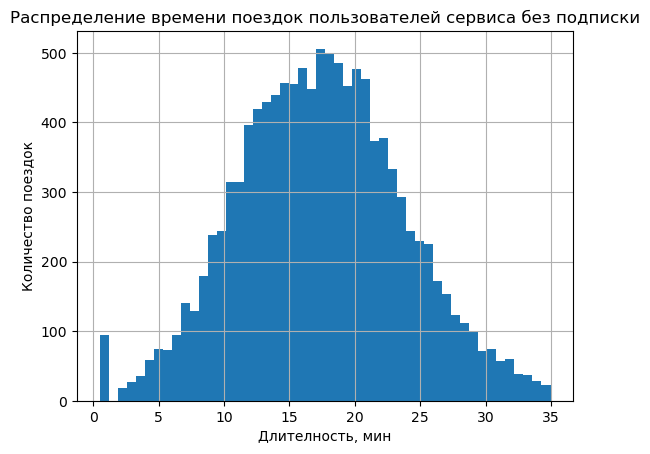

In [80]:
data_without_subscription['duration'].hist(bins=50)
plt.title('Распределение времени поездок пользователей сервиса без подписки')
plt.xlabel('Длителность, мин')
plt.ylabel('Количество поездок', rotation=90);

Итог шага №4: Был создан новый датафрейм, объединивший все 3 исходных датафрейма. Затем из него были сохранены 2 датафрейма: с данными пользователей с подпиской и без нее. Была визуализирована информация о расстоянии и времени поездок для пользователей обеих категорий. Средняя дальность поездки пользователей с подпиской составила 3149 м, а средняя длительность 18.2 минуты, а для пользователей без подписки - 3115 м и 17.3 минуты, соответственно. У пользователей без подписки значительно больше коротких поездок - до 1 км и в целом максимальная дальность поездки выше, чем у платных пользователей.

#### Шаг 5. Подсчёт выручки

In [54]:
data['duration'] = np.ceil(data['duration']) # округляем время доездок до целых минут (округление в большую сторону)

In [55]:
# Создаем датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4:
# находим суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
data_agg = data.pivot_table(index=['user_id', 'month'], values=['distance', 'duration'], aggfunc=['sum', 'count'])
data_agg.columns = ['_'.join(col).strip() for col in data_agg.columns.values]
data_agg = data_agg.reset_index()
data_agg = data_agg.rename(columns={'count_distance':'total_rides'})
data_agg = data_agg[['user_id', 'month', 'sum_distance', 'sum_duration', 'total_rides']]

In [56]:
data_agg.head()

,user_id,month,sum_distance,sum_duration,total_rides
0,1,2021-01-01,7027.511294,42.0,2
1,1,2021-04-01,754.159807,7.0,1
2,1,2021-08-01,6723.470560,46.0,2
3,1,2021-10-01,5809.911100,32.0,2
4,1,2021-11-01,7003.499363,56.0,3


In [57]:
# Из объединенного датафрейма создадим еще один с информацией о том, у какого пользователя какая подписка 
data_price = data[['user_id', 'subscription_type','minute_price', 'start_ride_price', 'subscription_fee']]
data_price = data_price.drop_duplicates()

In [58]:
data_price.head()

,user_id,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,ultra,6,0,199
12,2,ultra,6,0,199
23,3,ultra,6,0,199
35,4,ultra,6,0,199
49,5,ultra,6,0,199


In [59]:
# Объединим этот новый датафрейм с агрегированным по столбцу user_id
data_agg_price = data_agg.merge(data_price, on='user_id', how='inner')

In [60]:
data_agg_price.head()

,user_id,month,sum_distance,sum_duration,total_rides,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,2021-01-01,7027.511294,42.0,2,ultra,6,0,199
1,1,2021-04-01,754.159807,7.0,1,ultra,6,0,199
2,1,2021-08-01,6723.470560,46.0,2,ultra,6,0,199
3,1,2021-10-01,5809.911100,32.0,2,ultra,6,0,199
4,1,2021-11-01,7003.499363,56.0,3,ultra,6,0,199


In [61]:
data_agg_price.isna().sum() # проверяем датафрейм на пропуски

user_id              0
month                0
sum_distance         0
sum_duration         0
total_rides          0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [84]:
# Теперь добавим в этот новый датафрейм столбец с ежемесячной выручкой для каждого пользователя
data_agg_price['income'] = data_agg_price['start_ride_price'] * data_agg_price['total_rides'] + data_agg_price['sum_duration'] \
* data_agg_price['minute_price'] + data_agg_price['subscription_fee']

In [85]:
data_agg_price.head()

,user_id,month,sum_distance,sum_duration,total_rides,subscription_type,minute_price,start_ride_price,subscription_fee,income
0,1,2021-01-01,7027.511294,42.0,2,ultra,6,0,199,451.0
1,1,2021-04-01,754.159807,7.0,1,ultra,6,0,199,241.0
2,1,2021-08-01,6723.470560,46.0,2,ultra,6,0,199,475.0
3,1,2021-10-01,5809.911100,32.0,2,ultra,6,0,199,391.0
4,1,2021-11-01,7003.499363,56.0,3,ultra,6,0,199,535.0


Итог шага №5: Создали датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4. Нашли ежемесячную выручку для каждого пользователя. 

#### Шаг 6. Проверка гипотез

1. Проверяем гипотезу о том, что пользователи с подпиской тратят больше времени на поездки.

In [64]:
#Нулевая гипотеза: обе группы тратят одинаково
#Альтернативная: пользователи с подпиской тратят больше времени на поездки.

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data_with_subscription['duration'], data_without_subscription['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Вывод: пользователи с подпиской тратят больше времени на поездки

2. Проверяем гипотезу, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

In [65]:
# Нулевая гипотеза: средняя дальность поездки пользователей с подпиской равна 3130 метров
# Альтернативная: пользователи с подпиской в среднем проезжают значительно больше 3130 метров

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_1samp(data_with_subscription['distance'], 3130, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Вывод: не удалось опровергнуть нулевую гипотезу о том, что пользователи с подпиской в среднем проезжают 3130 метров за одну поездку.

3. Проверяем гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [66]:
# датафрейм с информацией о пользователях с подпиской
income_from_users_with_subscription = data_agg_price.query('subscription_type == "ultra"')

In [67]:
# датафрейм с информацией о пользователях без подписки
income_from_users_without_subscription = data_agg_price.query('subscription_type == "free"')

In [68]:
# Нулевая гипотеза: помесячная выручка от обеих групп одинаковая
# Альтернативная: помесячная выручка от пользователей с подпиской выше

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(income_from_users_with_subscription['income'], income_from_users_without_subscription['income'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Вывод: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ: Для проверки этой гипотезы нам бы подошел метод scipy.stats.ttest_rel, который принимает наборы данных — парные выборки до и после изменения. В нашем случае данному методу необходимо также передать параметр alternative='greater', проверится правосторонняя альтернативная гипотеза о том, что истинное среднее генеральной совокупности до изменения больше, чем истинное среднее генеральной совокупности после изменения.

#### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

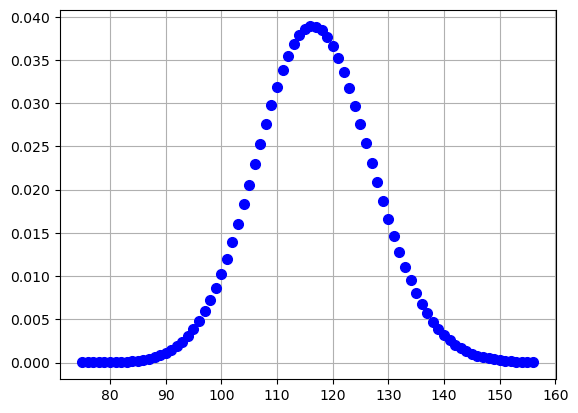

In [69]:
# задаём параметры биномиального распределения
n = 1168
p = 0.1

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 7
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=7)
ax.grid()

In [70]:
n = 1168
p = 0.1

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 100
result = distr.cdf(100)
result

0.050650790692463

Вывод: В данном случае процесс можно описать биномиальным распределением и т.к. выборка достаточно большая, то определить вероятность, при которой менее 100 пользователей захотят продлить подписку можно с помощью нормального распределения с мат.ожиданием n*p и ст.отклонением sqrt(n * p * (1 - p)), где n - величина выборки (количество промокодов), а р=0.1 (10% вероятность продления подписки пользователем). Изменяя n в обоих распределениях добиваемся результата, при котором вероятность получить менее 100 продлений подписки равна примерно 5%. Итоговое число промокодов - 1168.

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

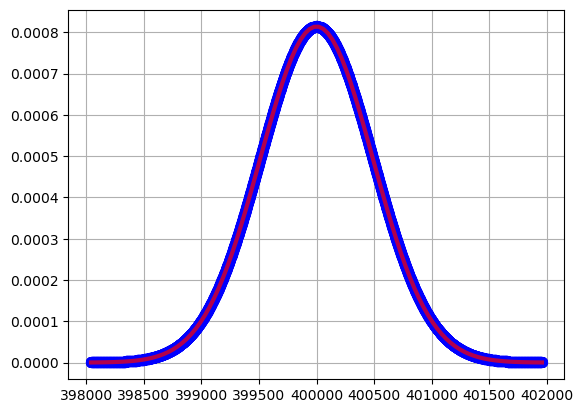

In [71]:
# зададим функцию, которая выдаёт <num> чисел, равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 7
ax.plot(x, binom.pmf(x, n, p), 'bo-', ms=7)

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.7
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.7)
ax.grid()

In [72]:
n = 1000000
p = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399.500 тысяч
result = distr.cdf(399500)
result

0.15371708296369768

Вывод: В данном случае процесс можно описать биномиальным распределением и т.к. выборка достаточно большая (1 млн уведомлений), то определить вероятность, при которой уведомления откроют менее 399500 пользователей можно с помощью нормального распределения с мат.ожиданием n*p и ст.отклонением sqrt(n * p * (1 - p)), где n - величина выборки (количество уведомлений), а р=0.4 (40% вероятность открытия уведомления пользователем). Вероятность того, что менее 399500 пользователей откроют уведомления равна примерно 15.4%.

#### Общие итоги исследования

Был проведен анализ данных пользователей сервиса аренды самокатов GoFast. 
Данные содержат информацию о пользователях из 8 городов России. Среди 8 городов наибольшее количество пользователей сервиса совершают поездки в Пятигорске (219 человек), а наименьшее в Москве (168 человек). 54% (835 человек) всех пользователей не имеют подписки на сервис, а 46% (699 человек) ее оформили. Большинство пользователей имеют возраст в интервале 22-28 лет. Средняя дальность поездки пользователя составляет 3133 метров, причем четверь всех поездок совершается на расстояние не превышающее 2543 м, а 3/4 всех поездок имеют дальность не более 3776 м. Средняя длительность поездки пользователя составляет 17.7 минут, причем длительность четверти всех поездок не превышает 13.6 минут, а 3/4 всех поездок имеют длительность не более 21.7 минут.
Несмотря на то, что соотношение числа пользователей с подпиской и без 46% на 54% (близкие по количеству группы) и пользователи с подпиской в среднем тратят больше времени на поездку, ежемесячные доходы больше от пользователей без подписки. Отделу маркетинга можно порекомендовать сфокусироваться больше на привлечении новых пользователей, чем на увеличении числа пользователей с подпиской.